In [1]:
# %matplotlib ipympl
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import torch
import torch.nn.functional as F
import os
import psutil
from utils.preprocess import *
from matplotlib.patches import Rectangle

# Get available memory
available_memory = psutil.virtual_memory().available

# Assuming np.float64
element_size = np.dtype(np.float64).itemsize

# Calculate max array size
max_array_size = available_memory / element_size

print(f"Maximum array size (np.float64): {max_array_size} elements")

Maximum array size (np.float64): 30025338368.0 elements


In [2]:
# Data loading Version 2 - toy data previously
data_root = '/scratch/bbsg/hangy6/RLS/data'
# patient_dir = f'{data_root}/patient01-08-27-2023'
# patient_dir = f'{data_root}/patient03-12-12-2023'
# patient_dir = f'{data_root}/patient04-12-14-2023'
# patient_dir = f'{data_root}/patient05-02-15-2024'
# patient_dir = f'{data_root}/patient06-02-17-2024'
# patient_dir = f'{data_root}/patient07-02-24-2024'
# patient_dir = f'{data_root}/patient08-02-29-2024'
# patient_dir = f'{data_root}/patient09-03-01-2024'
# patient_dir = f'{data_root}/patient10-03-14-2024'
# patient_dir = f'{data_root}/patient11-03-15-2024'
patient_dir = f'{data_root}/patient13-03-31-2024'
# patient_dir = f'{data_root}/patient14-04-03-2024'

print(f'Memory available before loading data: {psutil.virtual_memory().available}')
try:
    del matrices, timestamps, data
except:
    pass

window_size = 156
data_file = os.path.join(patient_dir, 'raw_pressure_data.npy')
timestamps_file = os.path.join(patient_dir, 'raw_timestamps.npy')
if os.path.exists(data_file) and os.path.exists(timestamps_file):
    print('load existing pressure data...')
    matrices = np.load(data_file).astype(np.float32)
    timestamps = np.load(timestamps_file)
    print(f'successfully loaded pressure data from {data_file} and timestamps from {timestamps_file}')
else:
    print('Generating pressure data from raw json file...')
    pressure_data = load_json(os.path.join(patient_dir, 'raw_data.json'))
    matrices, timestamps = get_pressure_matrices(pressure_data)
    np.save(data_file, np.array(matrices))
    np.save(data_file, np.array(timestamps))
    print('Successfully saved pressure data and timestamps')
    
data = get_data_chunks(matrices, timestamps, window_size)
print(f'Memory available after loading data: {psutil.virtual_memory().available}')
data.shape

Memory available before loading data: 240187592704
Generating pressure data from raw json file...
636283 data records loaded from /scratch/bbsg/hangy6/RLS/data/patient13-03-31-2024/raw_data.json!

Memory available after loading data: 227340820480


(4078, 156, 16, 16)

In [3]:
bar = data.sum(axis=(1,2,3)) != 0
np.save(f'{patient_dir}/win{window_size}_data_bar.npy', bar)
# plt.plot(np.arange(len(bar)), bar)
# cosine_matrix = cosine_similarity(data, data)
# plt.imshow(cosine_matrix)
# plt.colorbar()
# plt.savefig(f'{path}/win{window_size}_full_data_cosine_similarity.png')

In [11]:
def plot_bar(bars):
    bar_lens = [len(bar) for bar in bars]
    print(max(bar_lens))
    plt.xlim(0, max(bar_lens))
    plt.ylim(0, len(bars) * 0.2)
    for i in range(max(bar_lens)):
        for j in range(len(bars)):
            if len(bars[j]) <= i:
                continue
            color = 'red' if bars[j][i] else 'black'
            rect = Rectangle((i, 0.2 * j), 1, 0.1, edgecolor=color, facecolor=color, linewidth=0.1)
            plt.gca().add_patch(rect)
        

4078


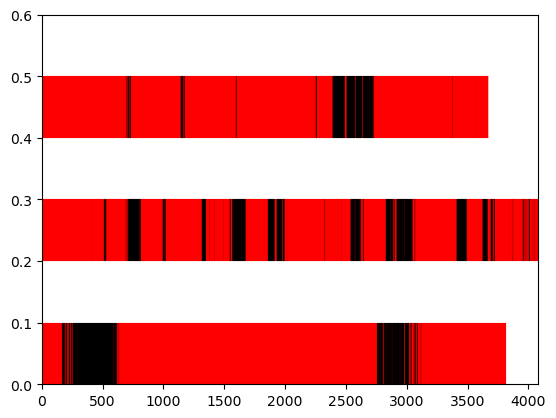

In [12]:
bar_filename = 'win156_data_bar.npy'
bars = [np.load(f'{data_root}/patient11-03-15-2024/' + bar_filename),\
        np.load(f'{data_root}/patient13-03-31-2024/' + bar_filename),\
        np.load(f'{data_root}/patient14-04-03-2024/' + bar_filename)]
# bars = [np.load(os.path.join(patient_dir, bar_filename))]
plot_bar(bars)
plt.savefig('sanity_check.png')